# Assignment 1: Transformations and Representations

Roll number: 2019101068


## 3. Transformations and Homogeneous Coordinates

1. Watch this [video](https://www.youtube.com/watch?v=PvEl63t-opM) to briefly understand homogeneous coordinates. 
### 1. What are points at infinity? 
### What type of transformation can you apply to transform a point from infinity to a point that is not at infinity? 
    
    
### 2. Find the vanishing point for the given images in the **data/Q3** folder. Complete function **FilterLines()** and  **GetVanishingPoint()** in the given starter code.

<br>
<hr>
<hr>
<hr>
<hr>

2. Using homogeneous coordinates we can represent different types of transformation as point transforms vs. frame transforms. Concatenation of transforms (whether you post multiply transformation matrices or pre-multiply transformation matrices) depends on the problem and how you are viewing it. Try to understand the difference between frame vs. point transformations from this [video](https://youtu.be/Za7Sdegf8m8?t=1834). We have 5 camera frames A, B, C, D and E. Given *frame* transformation $A \rightarrow B$ ,  $B \rightarrow C$ ,  $D \rightarrow C$ ,  $A \rightarrow E$. 

### Compute *frame transformation*  $D \rightarrow E$ (Be Careful with the inverses and stuff). 
### Also, given the co-ordinates of a point *x* in *D's* frame, what transformation is required to get *x's*  co-ordinates in *E's* frame? 



<img src="img/3.jpeg"  width="500" >



## Q1) WHat are points at infinity ?

We know that parallel lines no longer remain parallel when subjected to projective transformations. In such cases, the lines appear to meet at a point in the projection. Such a project, in the real world, does not appear. Since we say that parallel lines meet at infinity, we can say that their perspective projections (which are no longer parallel and actually meet at a point) meet at a point called the point of infinity.'

In short, point of infinity is simply a **mathematical convenience** which help us represent those points at which parallel lines appear to meet in the real world. This representation is done using homogenous coordinates.

Eg: for 2d projective space, such points have the form \[x, y, 0\] and since, to find real coordinates, we divide the entire representation by the last coordinate (zero in this case), the coordinates in the real world approach infinity.

## Q2) What type of transformation can you apply to transform a point from infinity to a point that is not at infinity? 

As mentioned above, applying a perspective transformation on a point at infinity (in N-d space) can lead a physical rendering (meeting point of parallel lines on a (N-1 D space) ). 
This phenomenon is commonly seen while dealing with camera matrices (a camera views the world in a projective manner).
Parallelism is NOT preserved during projective transformations and as a result, after projective transformation, the originally parallel lines may meet at a point.

### Vanishing points

In [1]:
import os
import cv2
import math
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
Images, ImageNames =[] , []

In [3]:
def ReadImage(InputImagePath):
    Images = []                     # Input Images will be stored in this list.
    ImageNames = []                 # Names of input images will be stored in this list.
    
    # Checking if path is of file or folder.
    if os.path.isfile(InputImagePath):						    # If path is of file.
        InputImage = cv2.imread(InputImagePath)                 # Reading the image.
        
        # Checking if image is read.
        if InputImage is None:
            print("Image not read. Provide a correct path")
            exit()
        
        Images.append(InputImage)                               # Storing the image.
        ImageNames.append(os.path.basename(InputImagePath))     # Storing the image's name.

    # If path is of a folder contaning images.
    elif os.path.isdir(InputImagePath):
        # Getting all image's name present inside the folder.
        for ImageName in os.listdir(InputImagePath):
            # Reading images one by one.
            InputImage = cv2.imread(InputImagePath + "/" + ImageName)

            Images.append(InputImage)                           # Storing images.
            ImageNames.append(ImageName)                        # Storing image's names.
        
    # If it is neither file nor folder(Invalid Path).
    else:
        print("\nEnter valid Image Path.\n")
        exit()

    return Images, ImageNames

In [4]:
def GetLines(Image):
    # Converting to grayscale
    GrayImage = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    # Blurring image to reduce noise.
    BlurGrayImage = cv2.GaussianBlur(GrayImage, (5, 5), 1)
    # Generating Edge image
    EdgeImage = cv2.Canny(BlurGrayImage, 40, 255)

    # Finding Lines in the image
    # https://stackoverflow.com/a/35795567/6427607
    Lines = cv2.HoughLinesP(EdgeImage, 1, np.pi / 180, 50, 10, 15)
    
    print("SHape of lines is ", Lines.shape)

    # Check if lines found and exit if not.
    if Lines is None:
        print("Not enough lines found in the image for Vanishing Point detection.")
        exit(0)
    
    return Lines


In [5]:
def fetch_image_with_lines(img, detected_lines):
    for line in detected_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    return img

In [6]:
def fetch_line_angle(line_arr):
    x1, y1, x2, y2 = line_arr
    if x1==x2:
        return 90 if y2-y1 >0 else -90
    else:
        # https://stackoverflow.com/a/10057866/6427607
        m = (y2-y1)/(x2-x1) 
        
        # Return the arc tangent of x, in radians. The result is between -pi/2 and pi/2.
        angle=math.degrees(math.atan(m))
        return angle
    
def is_vertical(line_theta, thres=7):
    diff1=math.fabs(90-line_theta)
    diff2=math.fabs((-90)-line_theta)
    #print("line theta is ", line_theta)
    return min(diff1, diff2)<=thres

def is_horizontal(line_theta, thres=7):
    diff=math.fabs(line_theta)
    return diff<=thres

In [7]:
def FilterLines(Lines):
    ans_lines = []
        
    for curr_line in Lines:
        
        tilt_angle=fetch_line_angle(curr_line)
        x1, y1, x2, y2 = curr_line
        
        if is_vertical(tilt_angle):
            continue
            
        if is_horizontal(tilt_angle):
            continue

        ans_lines.append(curr_line)

    print("Number of accepted lines is ", len(ans_lines))
    return ans_lines


In [8]:
def fetch_params(pts):
    x1, y1, x2, y2 = pts
    # when this func is called, we have already filtered out all  vertical lines
    # hence, no need to worry about degenerate case
    m = (y2-y1)/(x2-x1)
    c = y2-m*x1
    return (m,c)

In [9]:
def fetch_perpendicular_distance(m, c, x, y):
    num = math.fabs(m*x+c-y)
    denom=math.sqrt(m**2+1)
    dis=num/denom
    return dis**2

In [10]:
def GetVanishingPoint(final_lines):
    
    # TA said to apply a ransac type algorithm
    # recall RANSAC IN CV: camera calibration needed 4 points
    # To determine a point, we need 2 lines only
    # So, try all possible 2 line combinations and take the best
    # Use: mean of squared of perperdicular distances (instructed on Moodle) 
    least_error = None
    best_point= None
    
    params=[fetch_params(x) for x in final_lines]

    for i in range(len(final_lines)):        
        m1, c1 = params[i]
        
        for j in range(i+1, len(final_lines)):
            m2, c2 = params[j]

            # lines may be parallel in perspective projection as well
            if m1 != m2:
                pt_x = (c2 - c1) / (m1 - m2)
                pt_y = m2 * pt_x + c2

                err_arr=[fetch_perpendicular_distance(x[0], x[1], pt_x, pt_y) for x in params]
                
                tot_error=math.sqrt(sum(err_arr))
                if best_point is None:
                    least_error  = tot_error
                    best_point = (pt_x, pt_y)
                    
                else:
                    if tot_error<least_error:
                        least_error  = tot_error
                        best_point = (pt_x, pt_y)
                
    return best_point

In [11]:
Images, ImageNames = ReadImage("data/Q3")

In [12]:
Images[0].shape

(453, 677, 3)

In [13]:
import math

### See how do the lines actually look like

In [14]:
vis_images=deepcopy(Images)

path is  hall.jpeg
SHape of lines is  (45, 1, 4)
Lines shape is  (45, 4)
Shape of lines is  (45, 4)


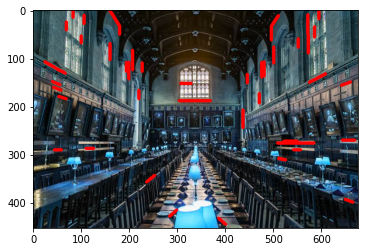

#################
path is  rail.jpg
SHape of lines is  (91, 1, 4)
Lines shape is  (91, 4)
Shape of lines is  (91, 4)


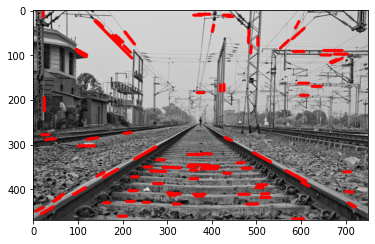

#################
path is  hyperspace.jpeg
SHape of lines is  (98, 1, 4)
Lines shape is  (98, 4)
Shape of lines is  (98, 4)


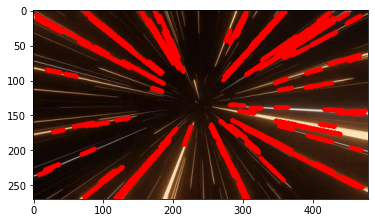

#################


In [15]:
for i in range(len(vis_images)):
    print("path is ", ImageNames[i])
    Image = vis_images[i]

    # Getting the lines form the image
    Lines = GetLines(Image)[:,0,:]
    
    print("Lines shape is ", Lines.shape)
    
    print("Shape of lines is ", Lines.shape)
    for Line in Lines:
        cv2.line(Image, (Line[0], Line[1]), (Line[2], Line[3]), (255, 0 , 0), 5)

    plt.imshow(Image)
    plt.show()
    print("#################")

## Observations

* In Hyperspace, all lines seem relevant and seem to converge at a single point.

* In Rail, in the real world, the rails and the wires in the air are parallel lines in the real world.

* In Hall, almost all horizontal lines (except the one near the window) are parallel in the real world.

### Refine and filter out lines (heuristically) until almost all lines left are supposedly parallel to each other in real world

SHape of lines is  (45, 1, 4)
Lines shape is  (45, 4)
Number of accepted lines is  14
Shape of FILTERED lines is  14


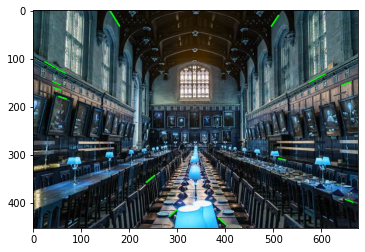

#################
SHape of lines is  (91, 1, 4)
Lines shape is  (91, 4)
Number of accepted lines is  28
Shape of FILTERED lines is  28


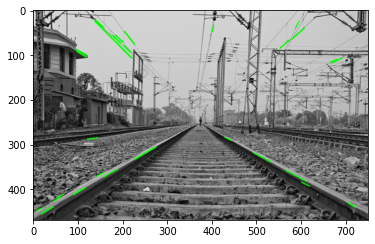

#################
SHape of lines is  (98, 1, 4)
Lines shape is  (98, 4)
Number of accepted lines is  91
Shape of FILTERED lines is  91


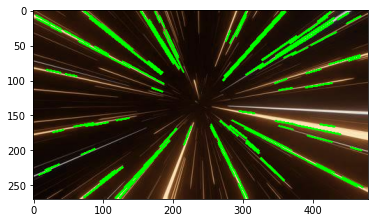

#################


In [16]:
for i in range(len(Images)):
    Image = Images[i]

    # Getting the lines form the image
    Lines = GetLines(Image)[:,0,:]
    
    print("Lines shape is ", Lines.shape)

    FilteredLines = FilterLines(Lines)
   
    print("Shape of FILTERED lines is ", len(FilteredLines))
    for Line in FilteredLines:
        cv2.line(Image, (Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
    
    # Showing the final image
    plt.imshow(Image)
    plt.show()
    print("#################")

### Filtered lines have been fixed. So, now calculate the vanishing points

SHape of lines is  (47, 1, 4)
Lines shape is  (47, 4)
Number of accepted lines is  12
Shape of FILTERED lines is  12


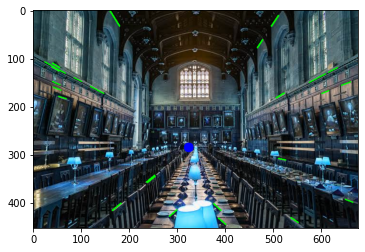

#################
SHape of lines is  (84, 1, 4)
Lines shape is  (84, 4)
Number of accepted lines is  17
Shape of FILTERED lines is  17


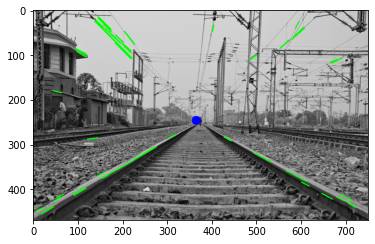

#################
SHape of lines is  (79, 1, 4)
Lines shape is  (79, 4)
Number of accepted lines is  69
Shape of FILTERED lines is  69


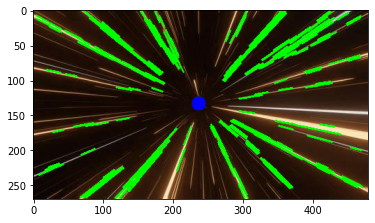

#################


In [17]:
for i in range(len(Images)):
    Image = Images[i]

    # Getting the lines form the image
    Lines = GetLines(Image)[:,0,:]
    
    print("Lines shape is ", Lines.shape)

    FilteredLines = FilterLines(Lines)

    VanishingPoint = GetVanishingPoint(FilteredLines)

    # Checking if vanishing point found
    if VanishingPoint is None:
        print("Vanishing Point not found. Possible reason is that not enough lines are found in the image for determination of vanishing point.")
        continue
    
    print("Shape of FILTERED lines is ", len(FilteredLines))
    for Line in FilteredLines:
        cv2.line(Image, (Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
    cv2.circle(Image, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)

    # Showing the final image
    #cv2.imshow("OutputImage", Image)
    #cv2.waitKey(0)
    
    # Showing the final image
    plt.imshow(Image)
    plt.show()
    print("#################")

# see part 2 in handwritten pdf